In [41]:
import pandas as pd
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:
# Configure testcase
form = "Cat"
num_config = 2
nb_vert = 200

filename = form+"_lv"+str(num_config)+"_"+str(nb_vert)+"_all.csv"
filename = "masks/" + filename

In [43]:
# Read data
data = pd.read_csv(filename) #, header=None)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [44]:
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

In [45]:
# Compare model sizes
model1 = Wide()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161

721


In [48]:
import copy
import numpy as np
import torch.optim as optim
import tqdm

def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 250   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        print(f"Epochs {epoch}: accuracy = {acc:.4f}")
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

In [49]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))

Epochs 0: accuracy = 0.7102
Epochs 1: accuracy = 0.8754
Epochs 2: accuracy = 0.8804
Epochs 3: accuracy = 0.8813
Epochs 4: accuracy = 0.8813
Epochs 5: accuracy = 0.8820
Epochs 6: accuracy = 0.8841
Epochs 7: accuracy = 0.8861
Epochs 8: accuracy = 0.8868
Epochs 9: accuracy = 0.8875
Epochs 10: accuracy = 0.8880
Epochs 11: accuracy = 0.8896
Epochs 12: accuracy = 0.8909
Epochs 13: accuracy = 0.8911
Epochs 14: accuracy = 0.8929
Epochs 15: accuracy = 0.8930
Epochs 16: accuracy = 0.8941
Epochs 17: accuracy = 0.8950
Epochs 18: accuracy = 0.8959
Epochs 19: accuracy = 0.8961
Epochs 20: accuracy = 0.8959
Epochs 21: accuracy = 0.8964
Epochs 22: accuracy = 0.8973
Epochs 23: accuracy = 0.8977
Epochs 24: accuracy = 0.8984
Epochs 25: accuracy = 0.8989
Epochs 26: accuracy = 0.8993
Epochs 27: accuracy = 0.9002
Epochs 28: accuracy = 0.9009
Epochs 29: accuracy = 0.9014
Epochs 30: accuracy = 0.9027
Epochs 31: accuracy = 0.9021
Epochs 32: accuracy = 0.9025
Epochs 33: accuracy = 0.9029
Epochs 34: accuracy = 0.

In [54]:
y_pred = model(X_train)
y_pred = y_pred.round()
y_pred

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)

In [58]:
np.where(y_pred == 1)

(array([   10,    11,    15, ..., 27994, 27996, 27999]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [59]:
X_train

tensor([[-0.9497,  0.7588],
        [-0.5779, -0.8191],
        [ 0.1558,  0.7990],
        ...,
        [ 0.7990,  0.5779],
        [-0.8894,  0.5176],
        [-0.5477, -0.4673]])

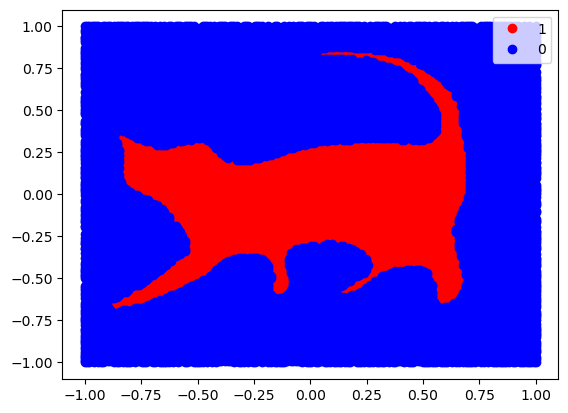

In [60]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X_train[y_train[:, 0] == 1, 0], X_train[y_train[:, 0] == 1, 1], 'ro', label='1')
plt.plot(X_train[y_train[:, 0] == 0, 0], X_train[y_train[:, 0] == 0, 1], 'bo', label='0')
plt.legend()

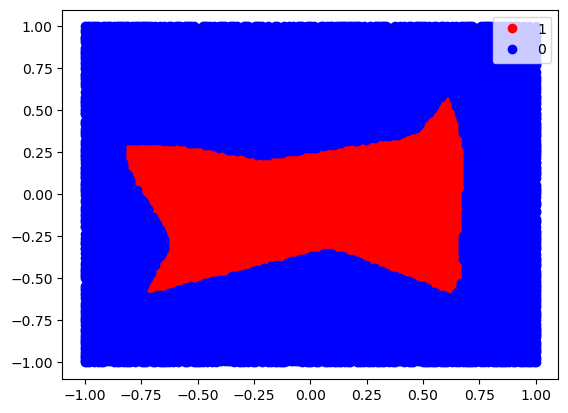

In [61]:
plt.figure()
plt.plot(X_train[y_pred[:, 0] == 1, 0], X_train[y_pred[:, 0] == 1, 1], 'ro', label='1')
plt.plot(X_train[y_pred[:, 0] == 0, 0], X_train[y_pred[:, 0] == 0, 1], 'bo', label='0')
plt.legend()

In [62]:
# save the model
torch.save(model.state_dict(), "wide_model.pth")